# Exploratory Data Analysis

## Imports

In [311]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [323]:
train: pd.DataFrame = pd.read_csv('data/no1_train.csv')
train.set_index('start_time', inplace=True)
test: pd.DataFrame = pd.read_csv('data/no1_validation.csv')
test.set_index('start_time', inplace=True)

y = train.pop('y')

# insert column with insert(location, column_name, column_value)

train.insert(0, 'y', y)


train.head()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
start_time,,,,,,,,,
2019-01-09 14:10:00,341.330021,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:15:00,330.114330,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:20:00,323.877221,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:25:00,296.438463,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4
2019-01-09 14:30:00,269.097132,1591.839,141.928,11.5,74.428,0.0,1819.695,10.0,-4417.4


In [313]:
train.describe()


,y,hydro,micro,thermal,wind,river,total,sys_reg,flow
count,225088.000000,225088.000000,225088.000000,225088.000000,225088.000000,225088.0,225088.000000,225088.000000,225088.000000
mean,8.907921,1888.334127,224.189826,21.803497,55.703266,0.0,2190.031963,-8.284305,-1999.055081
std,320.262539,401.000305,58.559855,3.579229,47.053033,0.0,444.077730,43.748315,1311.682286
min,-1579.680903,683.438000,80.371000,0.000000,0.000000,0.0,849.732000,-828.000000,-5541.200000
25%,-142.226700,1625.029000,185.017000,22.100000,15.704000,0.0,1916.523000,0.000000,-2996.700000
50%,-11.282351,1933.916000,225.938000,22.100000,41.848000,0.0,2248.874000,0.000000,-1953.700000
75%,127.454943,2175.595000,269.558000,24.100000,88.723000,0.0,2497.792000,0.000000,-906.900000
max,2956.333317,2995.524000,349.271000,25.700000,176.000000,0.0,3351.974000,474.000000,723.400000


## Data inspection

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

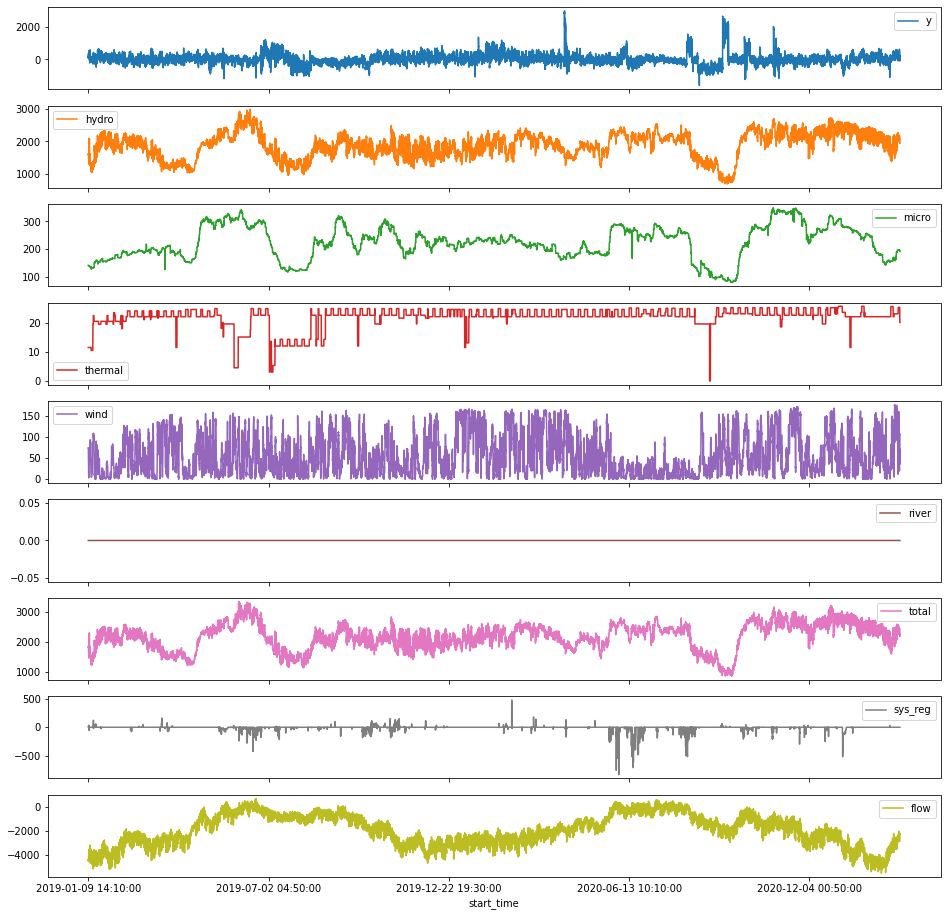

In [314]:
train.plot(subplots=True, figsize=(16,16))

<AxesSubplot:>

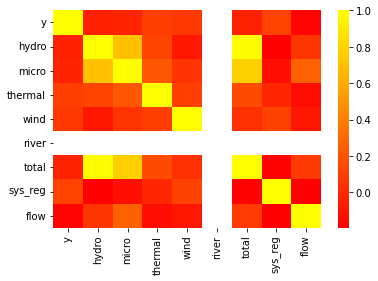

In [315]:
sns.heatmap(train.corr(), xticklabels=train.columns, yticklabels=train.columns, cmap='autumn')

### Preprocessing

array([<AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>,
       <AxesSubplot:xlabel='start_time'>], dtype=object)

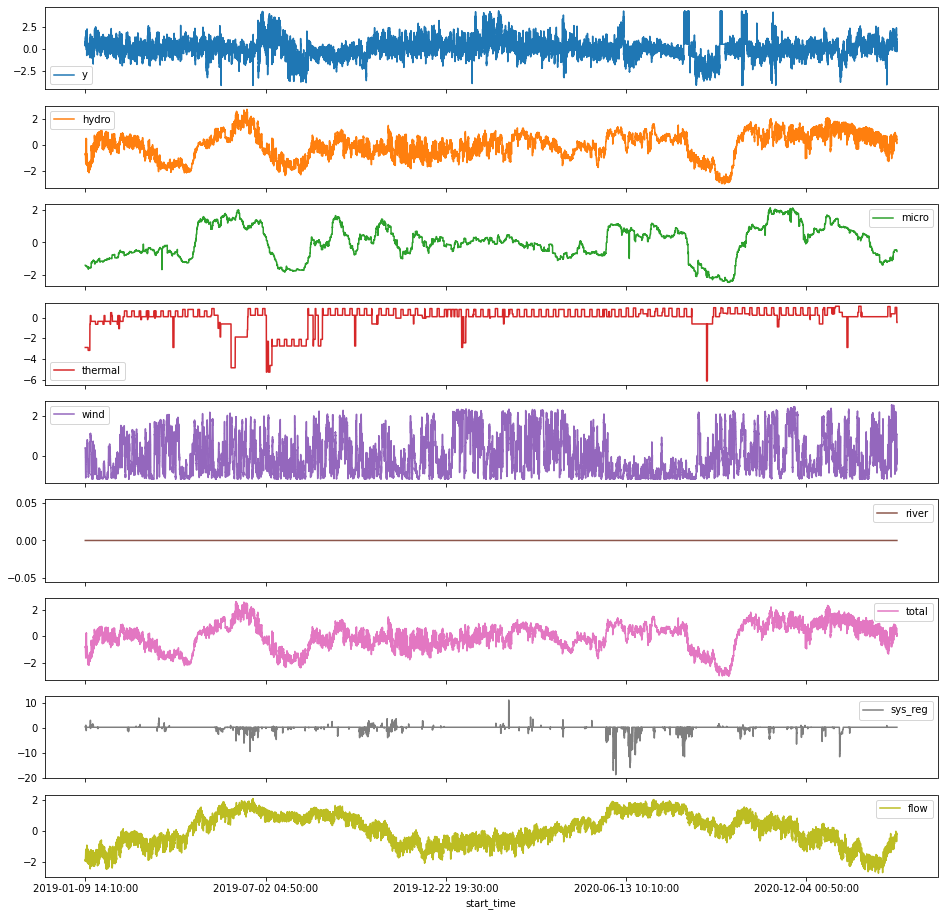

In [316]:
from preprocessing.preprocessor import Preprocessor

train_p = Preprocessor.clip(train, columns=['y'])
train_p = Preprocessor.scale(train_p)
train_p.plot(subplots=True, figsize=(16,16))

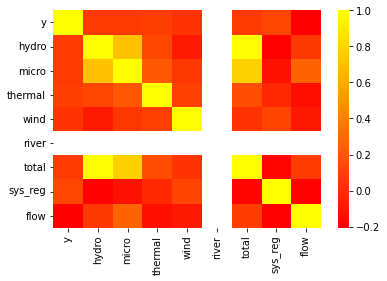

In [317]:
ax = sns.heatmap(train_p.corr(), xticklabels=train_p.columns, yticklabels=train_p.columns, cmap='autumn')
plt.show()

# Feature engineering

In [318]:
from preprocessing.feature_engineering import add_time_features

train_f = add_time_features(train_p)

In [319]:
train_f.sample()

,y,hydro,micro,thermal,wind,river,total,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,time_of_week,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,time_of_day_4,time_of_day_5
start_time,,,,,,,,,,,,,,,,,,,,
2019-10-22 18:50:00,1.1065,0.25584,1.418674,0.222535,1.213075,0.0,0.548426,0.189363,-0.169588,0,0,1,0,0,0,0,0,0,1,0


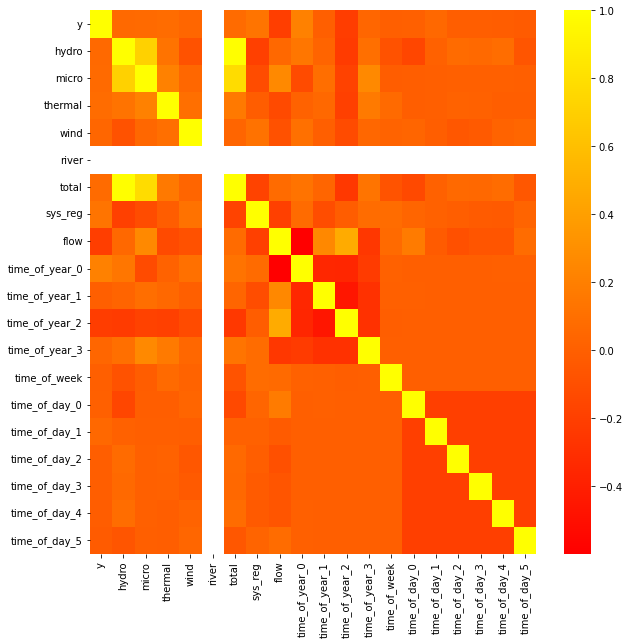

In [320]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(train_f.corr(), xticklabels=train_f.columns, yticklabels=train_f.columns, cmap='autumn')
plt.show()

# Train RNN model

In [321]:
y = train_f['y']
x = train_f.drop(columns=['y'])
x.head()

,hydro,micro,thermal,wind,river,total,sys_reg,flow,time_of_year_0,time_of_year_1,time_of_year_2,time_of_year_3,time_of_week,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,time_of_day_4,time_of_day_5
start_time,,,,,,,,,,,,,,,,,,,
2019-01-09 14:10:00,-0.73939,-1.404751,-2.878698,0.39795,0.0,-0.833948,0.417944,-1.843701,1,0,0,0,0,0,0,0,1,0,0
2019-01-09 14:15:00,-0.73939,-1.404751,-2.878698,0.39795,0.0,-0.833948,0.417944,-1.843701,1,0,0,0,0,0,0,0,1,0,0
2019-01-09 14:20:00,-0.73939,-1.404751,-2.878698,0.39795,0.0,-0.833948,0.417944,-1.843701,1,0,0,0,0,0,0,0,1,0,0
2019-01-09 14:25:00,-0.73939,-1.404751,-2.878698,0.39795,0.0,-0.833948,0.417944,-1.843701,1,0,0,0,0,0,0,0,1,0,0
2019-01-09 14:30:00,-0.73939,-1.404751,-2.878698,0.39795,0.0,-0.833948,0.417944,-1.843701,1,0,0,0,0,0,0,0,1,0,0


In [355]:
gen = TimeseriesGenerator(x, y, length=144, batch_size=128)
print(gen[0][0].shape, gen[0][1].shape)

(128, 144, 19) (128,)


In [357]:
from rnn.network import Network
input_shape = gen[0][0].shape[1:]
print(input_shape)
output_units = 1
net = Network(input_shape=input_shape, output_units=output_units, hidden_units=[256, 128, 128, 32])
net.model.fit(gen)

(144, 19)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 144, 256)          282624    
_________________________________________________________________
lstm_16 (LSTM)               (None, 144, 128)          197120    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 615,489
Trainable params: 615,489
Non-trainable params: 0
_________________________________________________________________
  36/1758 [..............................] - ETA: 2:26:40 - loss: 64270.6953

KeyboardInterrupt: 